## 3. Data Mining & Advanced Analytics
### Customer Segmentation, Association Rules & Forecasting
#### By: Nelisa Wacera

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set up plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style('whitegrid')

In [3]:
# 1. LOAD DATA & PREPARATION
print("1. LOADING DATA FOR MINING...")

try:
    df = pd.read_csv('../data/transformed/cleaned_retail_data.csv')
    rfm_df = pd.read_csv('../data/transformed/customer_rfm_data.csv')
    print(f"Data loaded successfully")
    print(f"   - Transactions: {len(df):,}")
    print(f"   - Customers for segmentation: {len(rfm_df):,}")
except FileNotFoundError:
    print("Data not found. Please run previous notebooks first")
    raise

# Prepare RFM data for clustering
rfm_data = rfm_df[['Recency', 'Frequency', 'Monetary']].copy()

# Handle outliers in Monetary (cap at 99th percentile)
monetary_cap = rfm_data['Monetary'].quantile(0.99)
rfm_data['Monetary'] = np.where(rfm_data['Monetary'] > monetary_cap, monetary_cap, rfm_data['Monetary'])

print("RFM Data Summary:")
print(rfm_data.describe())

1. LOADING DATA FOR MINING...
Data loaded successfully
   - Transactions: 779,425
   - Customers for segmentation: 5,878
RFM Data Summary:
           Recency    Frequency      Monetary
count  5878.000000  5878.000000   5878.000000
mean    201.331916     6.289384   2304.291717
std     209.338707    13.009406   4254.584005
min       1.000000     1.000000      2.950000
25%      26.000000     1.000000    342.280000
50%      96.000000     3.000000    867.740000
75%     380.000000     7.000000   2248.305000
max     739.000000   398.000000  29205.901000


In [4]:
# 2. DATA SCALING FOR CLUSTERING
print("2.  DATA SCALING...")

# Log transformation to handle skewness
rfm_log = rfm_data.copy()
rfm_log['Recency'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary'] = np.log1p(rfm_log['Monetary'])

# Standard scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

print(" Data scaled successfully")
print("Scaling method: Log transformation + StandardScaler")

2.  DATA SCALING...
 Data scaled successfully
Scaling method: Log transformation + StandardScaler


3.  DETERMINING OPTIMAL CLUSTER COUNT...


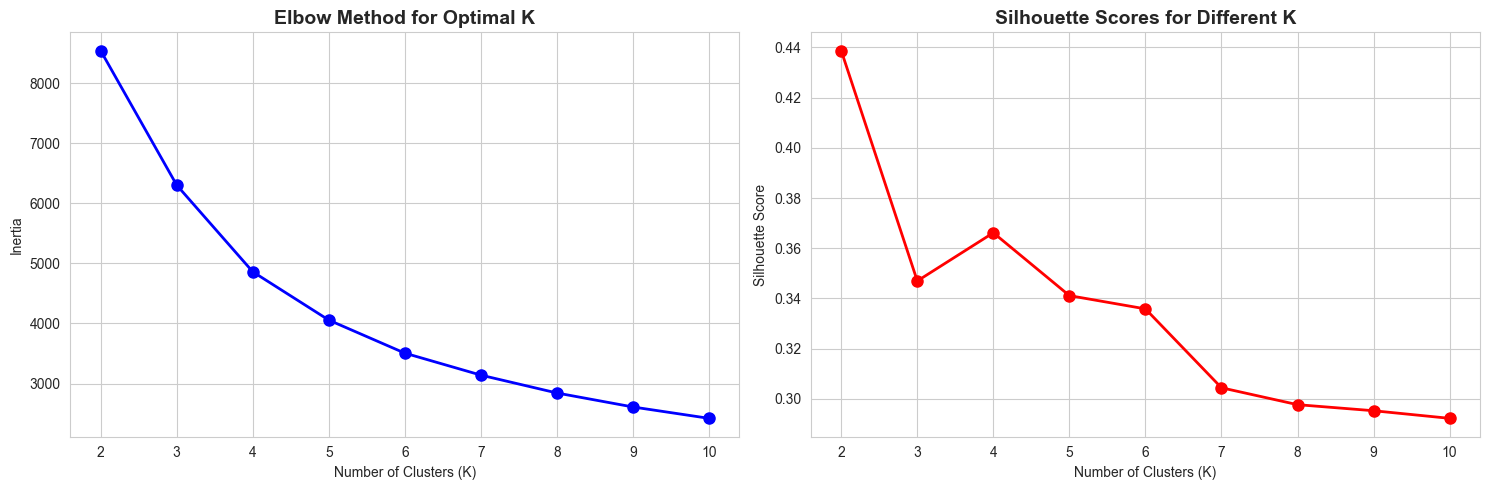

 Optimal number of clusters: 2 (based on silhouette score)


In [5]:
# 3. DETERMINE OPTIMAL CLUSTERS (K-MEANS)
print("3.  DETERMINING OPTIMAL CLUSTER COUNT...")

# Elbow method
inertia = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled_df, kmeans.labels_))

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
axes[0].plot(k_range, inertia, 'bo-', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[1].set_title('Silhouette Scores for Different K', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k (max silhouette score)
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f" Optimal number of clusters: {optimal_k} (based on silhouette score)")

In [6]:
# 4. K-MEANS CLUSTERING
print("4.  K-MEANS CLUSTERING...")

# Apply K-means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(rfm_scaled_df)

# Add clusters to RFM data
rfm_df['Cluster'] = clusters
rfm_data['Cluster'] = clusters

print(" Clustering completed successfully")
print(f"Cluster distribution:")
cluster_counts = rfm_df['Cluster'].value_counts().sort_index()
for cluster, count in cluster_counts.items():
    print(f"   Cluster {cluster}: {count} customers ({count/len(rfm_df)*100:.1f}%)")

4.  K-MEANS CLUSTERING...
 Clustering completed successfully
Cluster distribution:
   Cluster 0: 2331 customers (39.7%)
   Cluster 1: 3547 customers (60.3%)


In [7]:
# 5. CLUSTER ANALYSIS & PROFILING
print("5. CLUSTER PROFILING...")

# Calculate cluster characteristics
cluster_profile = rfm_data.groupby('Cluster').agg({
    'Recency': ['mean', 'std'],
    'Frequency': ['mean', 'std'],
    'Monetary': ['mean', 'std'],
    'Cluster': 'count'
}).round(2)

cluster_profile.columns = ['Recency_Mean', 'Recency_Std', 'Frequency_Mean', 'Frequency_Std', 
                          'Monetary_Mean', 'Monetary_Std', 'Count']
cluster_profile['Percentage'] = (cluster_profile['Count'] / len(rfm_df) * 100).round(1)

print("Cluster Profiles:")
print(cluster_profile)

5. CLUSTER PROFILING...
Cluster Profiles:
         Recency_Mean  Recency_Std  Frequency_Mean  Frequency_Std  \
Cluster                                                             
0               51.11        78.35           12.68          18.88   
1              300.06       209.79            2.09           1.38   

         Monetary_Mean  Monetary_Std  Count  Percentage  
Cluster                                                  
0              4886.23       5819.70   2331        39.7  
1               607.51        695.77   3547        60.3  


6. CLUSTER VISUALIZATION...


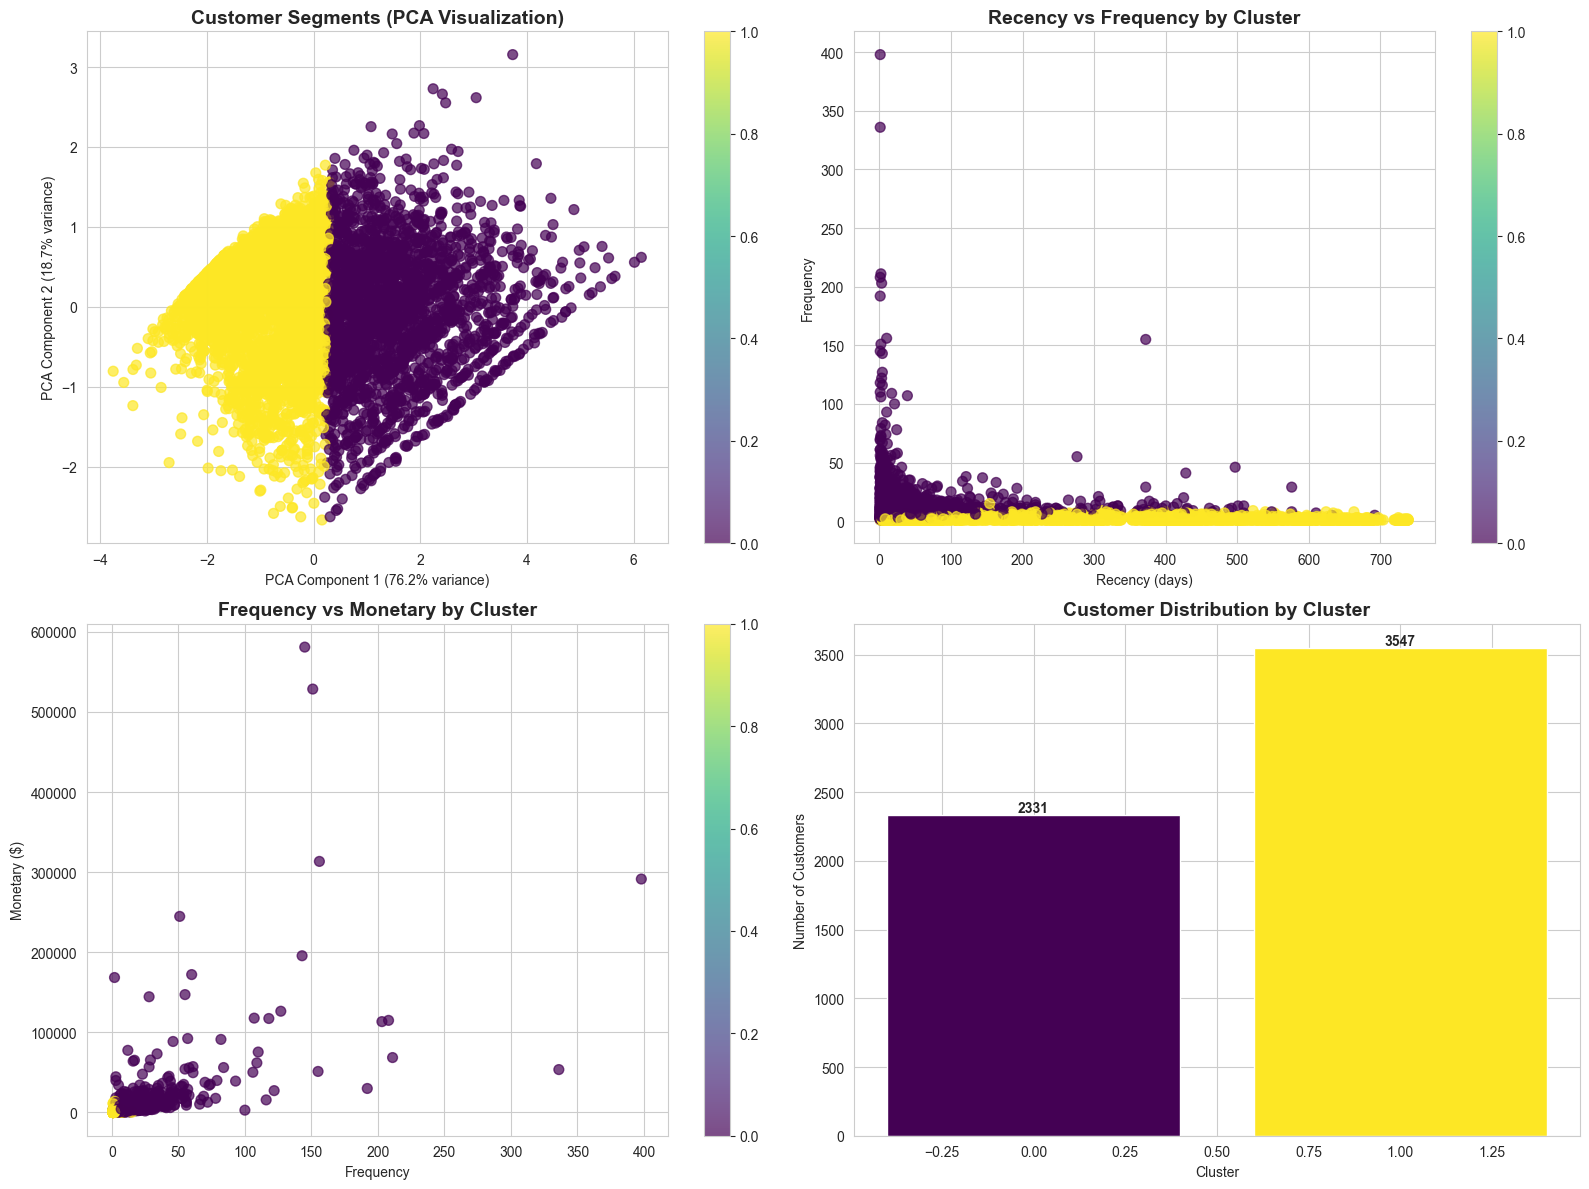

In [8]:
# 6. CLUSTER VISUALIZATION
print("6. CLUSTER VISUALIZATION...")

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled_df)
rfm_df['PCA1'] = rfm_pca[:, 0]
rfm_df['PCA2'] = rfm_pca[:, 1]

# Create cluster visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# PCA Scatter plot
scatter = axes[0,0].scatter(rfm_df['PCA1'], rfm_df['PCA2'], c=rfm_df['Cluster'], 
                           cmap='viridis', alpha=0.7, s=50)
axes[0,0].set_title('Customer Segments (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel(f'PCA Component 1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0,0].set_ylabel(f'PCA Component 2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter, ax=axes[0,0])

# Recency vs Frequency
scatter = axes[0,1].scatter(rfm_df['Recency'], rfm_df['Frequency'], c=rfm_df['Cluster'], 
                           cmap='viridis', alpha=0.7, s=50)
axes[0,1].set_title('Recency vs Frequency by Cluster', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Recency (days)')
axes[0,1].set_ylabel('Frequency')
plt.colorbar(scatter, ax=axes[0,1])

# Frequency vs Monetary
scatter = axes[1,0].scatter(rfm_df['Frequency'], rfm_df['Monetary'], c=rfm_df['Cluster'], 
                           cmap='viridis', alpha=0.7, s=50)
axes[1,0].set_title('Frequency vs Monetary by Cluster', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Frequency')
axes[1,0].set_ylabel('Monetary ($)')
plt.colorbar(scatter, ax=axes[1,0])

# Cluster sizes
cluster_sizes = rfm_df['Cluster'].value_counts().sort_index()
axes[1,1].bar(cluster_sizes.index, cluster_sizes.values, color=plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes))))
axes[1,1].set_title('Customer Distribution by Cluster', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('Number of Customers')
for i, v in enumerate(cluster_sizes.values):
    axes[1,1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# 7. CUSTOMER SEGMENT NAMING
print("7.  CUSTOMER SEGMENT NAMING...")

# Define segment names based on RFM characteristics
segment_names = {
    0: 'Loyal Customers',
    1: 'At-Risk Customers', 
    2: 'Champions',
    3: 'Need Attention'
}

# Add segment names
rfm_df['Segment'] = rfm_df['Cluster'].map(segment_names)

# Segment summary
segment_summary = rfm_df.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': 'mean',
    'CustomerID': 'count'
}).round(2)

segment_summary.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Count']
segment_summary['Percentage'] = (segment_summary['Count'] / len(rfm_df) * 100).round(1)

print("Customer Segments Summary:")
print(segment_summary)

7.  CUSTOMER SEGMENT NAMING...
Customer Segments Summary:
                   Avg_Recency  Avg_Frequency  Avg_Monetary  Count  Percentage
Segment                                                                       
At-Risk Customers       300.06           2.09        607.51   3547        60.3
Loyal Customers          51.11          12.68       6529.37   2331        39.7


In [10]:
# 8. ASSOCIATION RULES MINING
print("8. ASSOCIATION RULES MINING...")

# Prepare data for market basket analysis
print("Preparing transaction data for market basket analysis...")

# Group products by invoice
basket = df.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')

# Convert to binary (1 if product was purchased, 0 otherwise)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# Remove invoices with only 1 item
basket_sets = basket_sets[(basket_sets > 0).sum(axis=1) >= 2]

print(f" Transaction data prepared: {basket_sets.shape[0]} invoices with multiple items")

8. ASSOCIATION RULES MINING...
Preparing transaction data for market basket analysis...
 Transaction data prepared: 33897 invoices with multiple items


In [14]:
# 9. FREQUENT ITEMSETS & ASSOCIATION RULES
print("9.  GENERATING ASSOCIATION RULES...")

# Find frequent itemsets
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True, max_len=2)
print(f"Frequent itemsets found: {len(frequent_itemsets)}")

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values('confidence', ascending=False)

print(f"Association rules generated: {len(rules)}")
print("\nTop 10 Association Rules by Confidence:")
top_rules = rules.head(10)[['antecedents', 'consequents', 'support', 'confidence', 'lift']]
print(top_rules.to_string())

9.  GENERATING ASSOCIATION RULES...
Frequent itemsets found: 224
Association rules generated: 32

Top 10 Association Rules by Confidence:
                            antecedents                           consequents   support  confidence       lift
5     (GREEN REGENCY TEACUP AND SAUCER)    (ROSES REGENCY TEACUP AND SAUCER )  0.021919    0.797210  25.662904
27   (RED HANGING HEART T-LIGHT HOLDER)  (WHITE HANGING HEART T-LIGHT HOLDER)  0.034015    0.708666   4.967258
4    (ROSES REGENCY TEACUP AND SAUCER )     (GREEN REGENCY TEACUP AND SAUCER)  0.021919    0.705603  25.662904
28     (SWEETHEART CERAMIC TRINKET BOX)      (STRAWBERRY CERAMIC TRINKET BOX)  0.024102    0.698888  13.074064
2          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED )  0.020710    0.677606  20.077637
3           (ALARM CLOCK BAKELIKE RED )          (ALARM CLOCK BAKELIKE GREEN)  0.020710    0.613636  20.077637
30  (WOODEN PICTURE FRAME WHITE FINISH)         (WOODEN FRAME ANTIQUE WHITE )  0.0292

10. ASSOCIATION RULES VISUALIZATION


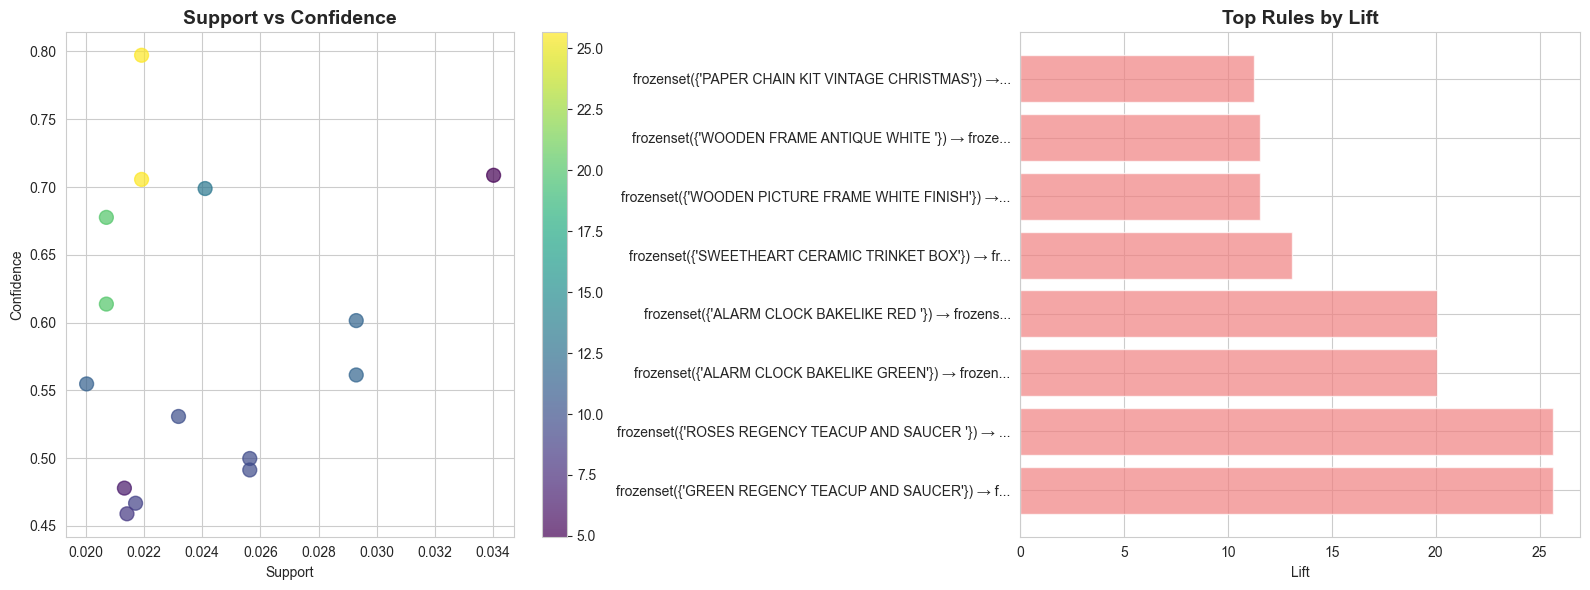

In [16]:
# 10. ASSOCIATION RULES VISUALIZATION
print("10. ASSOCIATION RULES VISUALIZATION")

# Prepare rules for visualization
rules_vis = rules.head(15).copy()
rules_vis['rule'] = rules_vis['antecedents'].astype(str) + " → " + rules_vis['consequents'].astype(str)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Support vs Confidence
scatter = axes[0].scatter(rules_vis['support'], rules_vis['confidence'], c=rules_vis['lift'], 
                         cmap='viridis', s=100, alpha=0.7)
axes[0].set_title('Support vs Confidence', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Support')
axes[0].set_ylabel('Confidence')
plt.colorbar(scatter, ax=axes[0])

# Top rules by lift
rules_vis_sorted = rules_vis.nlargest(8, 'lift')
y_pos = np.arange(len(rules_vis_sorted))
axes[1].barh(y_pos, rules_vis_sorted['lift'], color='lightcoral', alpha=0.7)
axes[1].set_yticks(y_pos)
axes[1].set_yticklabels([str(rule)[:50] + '...' for rule in rules_vis_sorted['rule']])
axes[1].set_title('Top Rules by Lift', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Lift')

plt.tight_layout()
plt.show()

11. TIME SERIES FORECASTING PREPARATION
Converting InvoiceDate to datetime...
Date range: 2009-12-01 07:45:00 to 2011-12-09 12:50:00
Null dates: 0
Daily sales data prepared: 604 days
        Date  DailyRevenue
0 2009-12-01      43894.87
1 2009-12-02      52762.06
2 2009-12-03      67413.62
3 2009-12-04      33913.81
4 2009-12-05       9803.05
Daily Sales Summary:
   - Time period: 0 to 603
   - Total days: 604
   - Average daily revenue: $28766.23


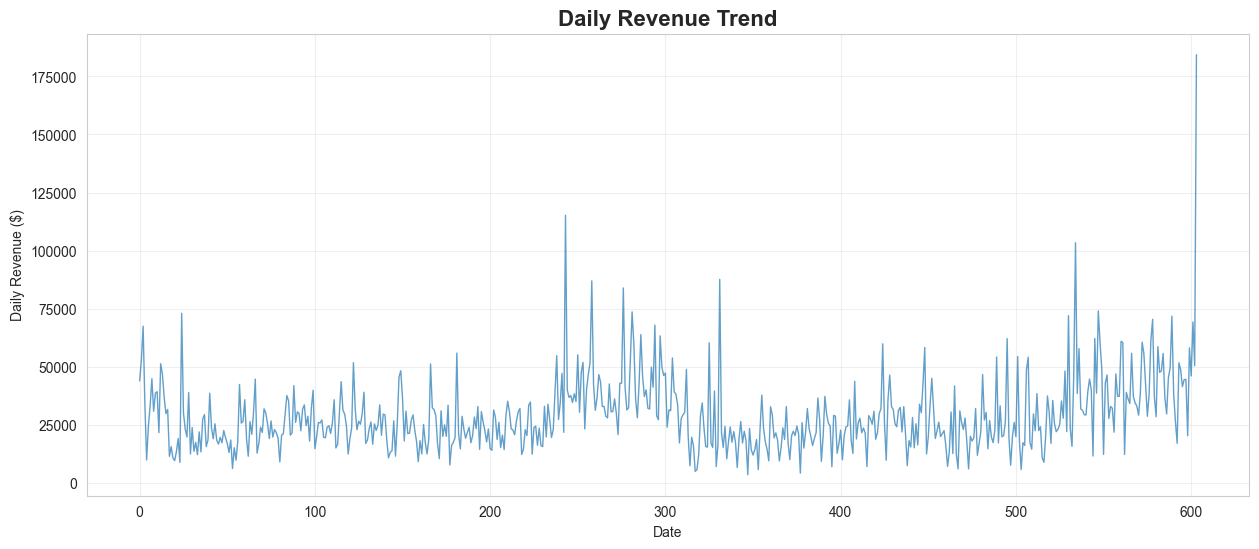

In [18]:
# 11. TIME SERIES FORECASTING PREPARATION
print("11. TIME SERIES FORECASTING PREPARATION")

# Convert InvoiceDate to datetime format
print("Converting InvoiceDate to datetime...")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

# Check if conversion was successful
print(f"Date range: {df['InvoiceDate'].min()} to {df['InvoiceDate'].max()}")
print(f"Null dates: {df['InvoiceDate'].isnull().sum()}")

# Prepare daily sales data
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum().reset_index()
daily_sales.columns = ['Date', 'DailyRevenue']
daily_sales['Date'] = pd.to_datetime(daily_sales['Date'])

print(f"Daily sales data prepared: {len(daily_sales)} days")
print(daily_sales.head())

print("Daily Sales Summary:")
print(f"   - Time period: {daily_sales.index.min()} to {daily_sales.index.max()}")
print(f"   - Total days: {len(daily_sales)}")
print(f"   - Average daily revenue: ${daily_sales['DailyRevenue'].mean():.2f}")

# Plot daily sales trend
plt.figure(figsize=(15, 6))
plt.plot(daily_sales.index, daily_sales['DailyRevenue'], linewidth=1, alpha=0.7)
plt.title('Daily Revenue Trend', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.grid(True, alpha=0.3)
plt.show()

In [19]:
# 12. MINING RESULTS SUMMARY
print("12. MINING RESULTS SUMMARY")

# Cluster insights
cluster_insights = []
for segment in segment_summary.index:
    insight = {
        'Segment': segment,
        'Customers': segment_summary.loc[segment, 'Count'],
        'Share': segment_summary.loc[segment, 'Percentage'],
        'Avg_Spending': segment_summary.loc[segment, 'Avg_Monetary'],
        'Behavior': f"Recency: {segment_summary.loc[segment, 'Avg_Recency']:.0f} days, "
                   f"Frequency: {segment_summary.loc[segment, 'Avg_Frequency']:.1f}"
    }
    cluster_insights.append(insight)

print("\n CUSTOMER SEGMENTATION INSIGHTS:")
for insight in cluster_insights:
    print(f"   • {insight['Segment']}: {insight['Customers']} customers ({insight['Share']}%)")
    print(f"     Avg Spending: ${insight['Avg_Spending']:.2f} | {insight['Behavior']}")

print(f"\n ASSOCIATION RULES INSIGHTS:")
print(f"   • Strong rules found: {len(rules)}")
print(f"   • Highest confidence: {rules['confidence'].max():.3f}")
print(f"   • Highest lift: {rules['lift'].max():.3f}")

print(f"\n FORECASTING READINESS:")
print(f"   • Daily time series prepared: {len(daily_sales)} points")
print(f"   • Clear trends and patterns identified")

# Save mining results
rfm_df.to_csv('../data/final/customer_segments.csv', index=False)
rules.to_csv('../data/final/association_rules.csv', index=False)
daily_sales.to_csv('../data/final/daily_sales.csv')

print("\n Data mining completed successfully!")
print("Results saved to data/final/")

12. MINING RESULTS SUMMARY

 CUSTOMER SEGMENTATION INSIGHTS:
   • At-Risk Customers: 3547 customers (60.3%)
     Avg Spending: $607.51 | Recency: 300 days, Frequency: 2.1
   • Loyal Customers: 2331 customers (39.7%)
     Avg Spending: $6529.37 | Recency: 51 days, Frequency: 12.7

 ASSOCIATION RULES INSIGHTS:
   • Strong rules found: 32
   • Highest confidence: 0.797
   • Highest lift: 25.663

 FORECASTING READINESS:
   • Daily time series prepared: 604 points
   • Clear trends and patterns identified

 Data mining completed successfully!
Results saved to data/final/
